# Importando as dependencias

In [14]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import numpy as np

# Data Set
Carregando o DataSet de imagens originais e manipuladas

In [28]:
# CASIA 1 -> 384x256, 800 authentic, 921 tampered
# CASIA 2 -> 240x160 && 900x600, 7492 authentic, 5123 tampered
# IMD2020 -> custom size, 414 authentic, 2010 tampered
image_height = 128
image_width = 128
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_height, image_width)
image_shape = image_size + (image_color_channel,)

batch_size = 24
class_names = ['authentic', 'tampered']

In [29]:
# CASIA1 CASIA2 ELA_CASIA1
dataset_dir = os.path.join('D:', 'data_sets', 'general_image_tampering', 'CASIA', 'CASIA1')

original_dir = os.path.join(dataset_dir, 'authentic')
tampered_dir = os.path.join(dataset_dir, 'tampered')

original_images = os.listdir(original_dir)
tampered_images = os.listdir(tampered_dir)

original_images_count = len(original_images)
tampered_images_count = len(tampered_images)

print('Number of original images: ', original_images_count)

print('Number of tampered images: ', tampered_images_count)

Number of original images:  800
Number of tampered images:  921


# Batch Creation

In [30]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'training'
)

Found 1721 files belonging to 2 classes.
Using 1377 files for training.


In [31]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation'
)

Found 1721 files belonging to 2 classes.
Using 344 files for validation.


In [32]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

# Utilizado para testar o modelo depois do término do treino do modelo
dataset_test = dataset_validation.take(dataset_validation_batches)
# Utilizado para avaliar o modelo ainda durante o treinamento
dataset_validation = dataset_validation.skip(dataset_validation_batches)

In [33]:
count_train = 0
count_authentic = 0
count_tampered = 0
for image_batch, label_batch in dataset_train:
    count_train += len(image_batch)
    count_authentic += len(label_batch[label_batch == 0])
    count_tampered += len(label_batch[label_batch == 1])

print('Number of training images: ', count_train)
print('Number of training authentic images: ', count_authentic)
print('Number of training tampered images: ', count_tampered)
print('Proportion of authentic images: ', count_authentic / count_train)

count_validation = 0
count_authentic = 0
count_tampered = 0
for image_batch, label_batch in dataset_validation:
    count_validation += len(image_batch)
    count_authentic += len(label_batch[label_batch == 0])
    count_tampered += len(label_batch[label_batch == 1])

print('Number of validation images: ', count_validation)
print('Number of validation authentic images: ', count_authentic)
print('Number of validation tampered images: ', count_tampered)
print('Proportion of authentic images: ', count_authentic / count_validation)

count_test = 0
count_authentic = 0
count_tampered = 0
for image_batch, label_batch in dataset_test:
    count_test += len(image_batch)
    count_authentic += len(label_batch[label_batch == 0])
    count_tampered += len(label_batch[label_batch == 1])

print('Number of test images: ', count_test)
print('Number of test authentic images: ', count_authentic)
print('Number of test tampered images: ', count_tampered)
print('Proportion of authentic images: ', count_authentic / count_test)


Number of training images:  1377
Number of training authentic images:  652
Number of training tampered images:  725
Proportion of authentic images:  0.4734931009440813
Number of validation images:  272
Number of validation authentic images:  116
Number of validation tampered images:  156
Proportion of authentic images:  0.4264705882352941
Number of test images:  72
Number of test authentic images:  33
Number of test tampered images:  39
Proportion of authentic images:  0.4583333333333333


# Data Augmentation

In [34]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Feature Extraction

In [35]:
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
feature_extractor.trainable = False

feature_extractor.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

# Model

In [36]:
epochs = 10
learning_rate = 1e-4

adapt_learn_rate = lambda epoch: 1e-4 * 10**(epoch / 20)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.LearningRateScheduler(adapt_learn_rate)
]

In [37]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
            32, (5, 5), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=image_shape),
        data_augmentation,
        feature_extractor,
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# inputs = tf.keras.Input(shape=image_shape)
# x = feature_extractor(inputs, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# model = tf.keras.Model(inputs, outputs)

In [20]:
tf.keras.backend.clear_session()

model = build_model()

model.compile(
    tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives()
    ]
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      


                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)       0         
 g2D)                                                            
          

In [21]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)
history_dict = history.history

Epoch 1/20


33/58 [================>.............] - ETA: 44s - loss: 1.9378 - binary_accuracy: 0.5366 - precision: 0.5561 - recall: 0.5628 - auc: 0.5461 - true_positives: 233.0000 - true_negatives: 192.0000 - false_positives: 186.0000 - false_negatives: 181.0000

KeyboardInterrupt: 

## Save Model

In [14]:
path = os.path.join('models', 'ELA_IFAKE_PROPOSED_CASIA_1_20_EPOCHS')

model.save(os.path.join(path,'model.h5'))

json.dump(history_dict, open(os.path.join(path, 'model_history.json'), 'w'))

c:\Repositories\projects\my-projects\tensor-flow-test\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Model

In [38]:
path = os.path.join('models', 'VGG16_IMAGENET_CASIA1_20_EPOCHS')

model = tf.keras.models.load_model(os.path.join(path, 'model.h5'))

history_dict = json.load(open(os.path.join(path, 'model_history.json'), 'r'))

# Model Evaluation

### Loss Curve

Text(0.5, 1.0, 'Loss')

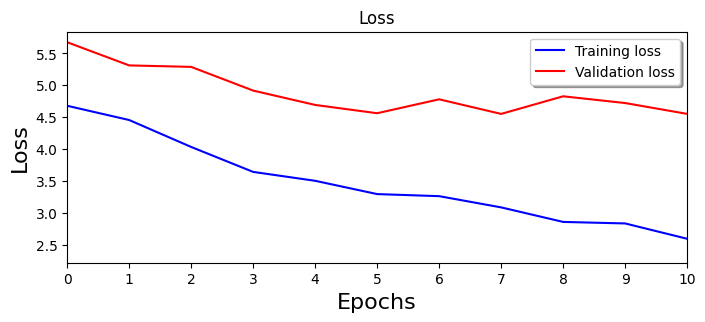

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(history_dict['loss'], color='b', label="Training loss")
ax.plot(history_dict['val_loss'], color='r', label="Validation loss")
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(loc='best', shadow=True)
ax.set_xlim(0,epochs)
ax.set_xticks(np.arange(0, epochs+1, 1))
ax.set_title('Loss')

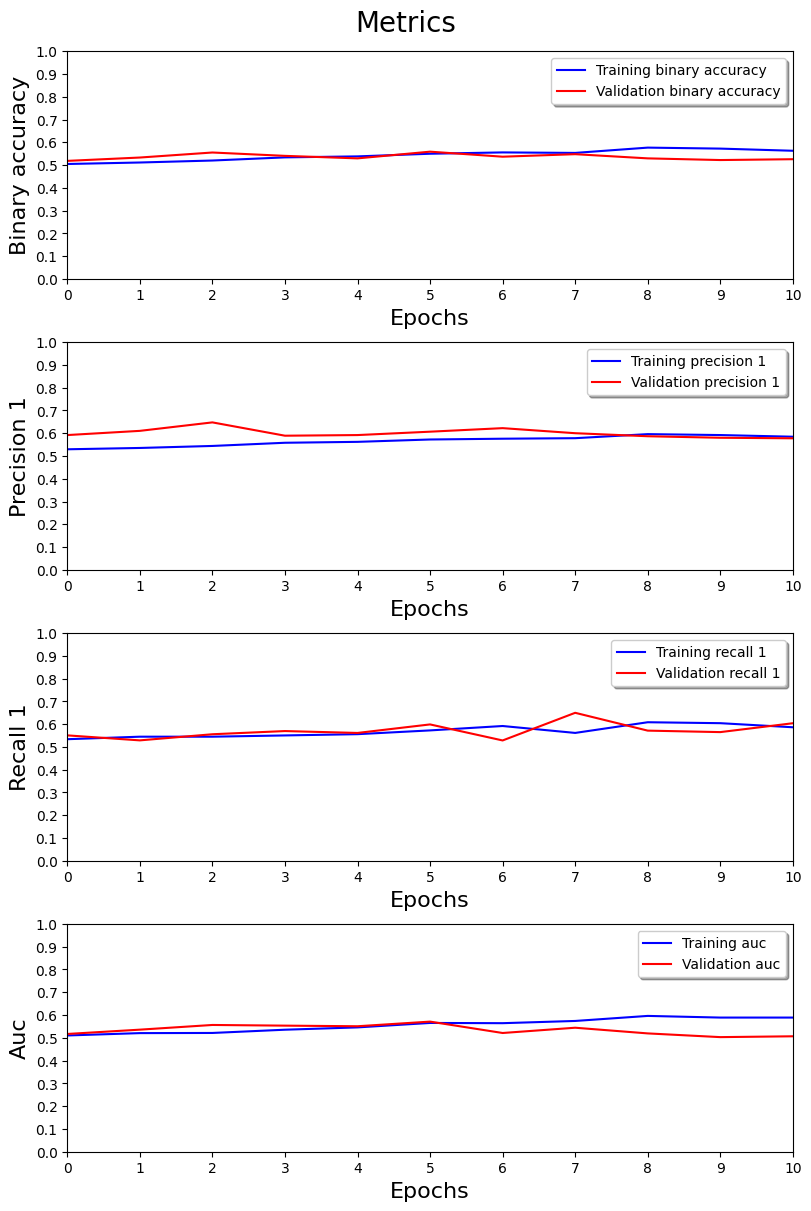

In [40]:
plot_metrics = [key for key in history_dict.keys() if key.split('_')[0] != 'val' and 'positives' not in key and 'negatives' not in key and key != 'loss']
plot_size = len(plot_metrics)

if plot_size > 0:
    fig, ax = plt.subplots(plot_size,1,figsize=(8,3*plot_size), constrained_layout=True, sharey=True)
    for i, metric in enumerate(plot_metrics):
        ax[i].plot(history_dict[metric], color='b', label='Training ' + metric.replace('_', ' '))
        ax[i].plot(history_dict['val_'+metric], color='r', label='Validation ' + metric.replace('_', ' '))
        ax[i].set_xlabel('Epochs',fontsize=16)
        ax[i].set_ylabel(metric.replace('_', ' ').capitalize(),fontsize=16)
        ax[i].set_ylim(0,1)
        ax[i].set_yticks(np.arange(0, 1.1, 0.1))
        ax[i].set_xlim(0,epochs)
        ax[i].set_xticks(np.arange(0, epochs+1, 1))
        legend = ax[i].legend(loc='best', shadow=True)

    fig.suptitle('Metrics',fontsize=20)

In [26]:
plot_metrics = [key for key in history_dict.keys() if key.split('_')[0] != 'val' and ('positives' in key or 'negatives' in key)]
plot_size = len(plot_metrics)
if plot_size > 0:
    fig, ax = plt.subplots(plot_size,1,figsize=(8,4*plot_size), constrained_layout=True, sharey=True)
    for i, metric in enumerate(plot_metrics):
        ax[i].plot([value/count_train for value in history_dict[metric]], color='b', label='Training ' + metric.replace('_', ' '))
        ax[i].plot([value/count_validation for value in history_dict['val_'+metric]], color='r', label='Validation ' + metric.replace('_', ' '))
        ax[i].set_xlabel('Epochs',fontsize=16)
        ax[i].set_ylabel(metric.replace('_', ' ').capitalize(),fontsize=16)
        ax[i].set_ylim(0,1)
        ax[i].set_yticks(np.arange(0, 1.1, 0.1))
        ax[i].set_xlim(0,epochs)
        ax[i].set_xticks(np.arange(0, epochs+1, 1))
        legend = ax[i].legend(loc='best', shadow=True)

In [43]:
test_results = model.evaluate(dataset_test)

for name, value in zip(model.metrics_names, test_results):
    print(name, ': ', value)

3/3 [==============================] - 3s 934ms/step - loss: 4.1295 - binary_accuracy: 0.4861 - precision_1: 0.4681 - recall_1: 0.6471 - auc: 0.4981
loss :  4.129499435424805
binary_accuracy :  0.4861111044883728
precision_1 :  0.4680851101875305
recall_1 :  0.6470588445663452
auc :  0.4980649948120117


In [56]:
total = count_test
correct = 0
for image_batch, label_batch in dataset_test:
    print('Predictions: ', model.predict(image_batch))
    print('Labels: ', label_batch)


1/1 [==============================] - 1s 897ms/step
Predictions:  [[9.7289401e-01]
 [2.2908454e-03]
 [5.3620599e-03]
 [1.0000000e+00]
 [7.1002305e-01]
 [1.6934281e-02]
 [9.4857711e-01]
 [9.9985981e-01]
 [9.9999988e-01]
 [9.9999970e-01]
 [9.9212632e-02]
 [4.7691583e-07]
 [2.9295200e-01]
 [9.9994707e-01]
 [2.9368000e-03]
 [5.0504089e-14]
 [1.4893304e-05]
 [9.9939138e-01]
 [5.4890690e-05]
 [9.9999774e-01]
 [9.5272785e-01]
 [8.0857021e-01]
 [9.9249476e-01]
 [1.3920996e-10]]
Labels:  tf.Tensor([1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0], shape=(24,), dtype=int32)


In [13]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(16):

        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        
        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]] + ' (' + class_names[labels[i]] + ')')

Labels:      [1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1]
Predictions: [0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1]


<Figure size 640x480 with 0 Axes>

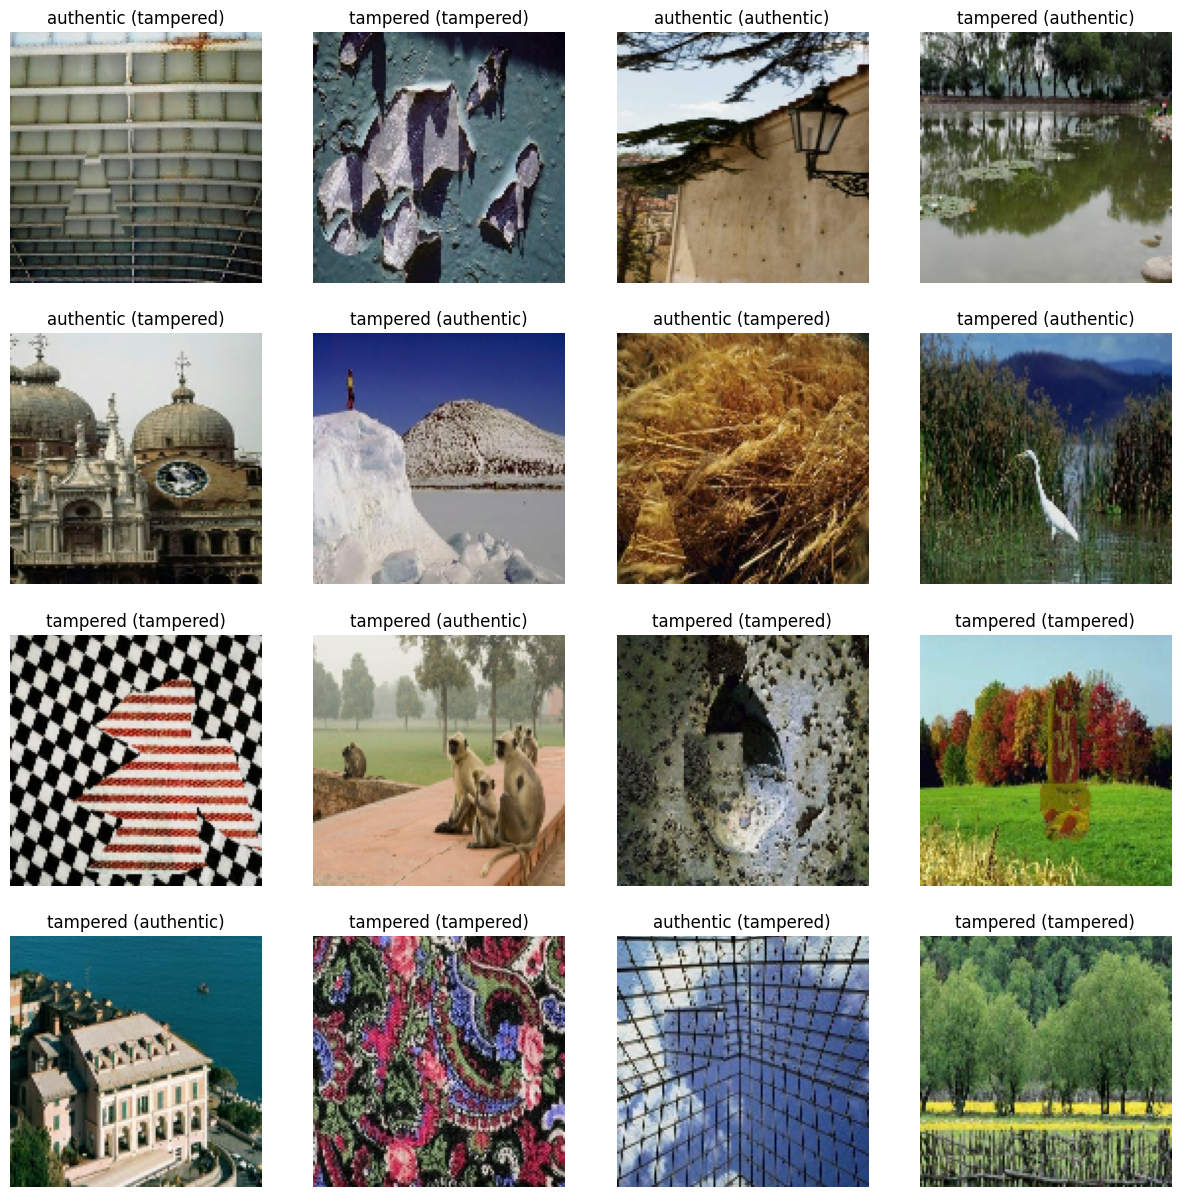

In [14]:
plot_dataset_predictions(dataset_test)

In [ ]:
def predict_image(image_path, label):
    image_to_predict = tf.keras.preprocessing.image.load_img(image_path, target_size = image_size)
    image_to_predict = tf.keras.preprocessing.image.img_to_array(image_to_predict)
    image_to_predict = tf.expand_dims(image_to_predict, 0)

    prediction = model.predict(image_to_predict)
    prediction = tf.where(prediction < 0.5, 0, 1)
    if prediction == label:
        return True
    else:
        return False

In [ ]:

for image in original_images:
    predict_image(os.path.join(original_dir, image), 0)

# Heat Map using Grad-CAM

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [65]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [
            model.get_layer('vgg16').get_layer('input_1').input,
        ],
        [
            model.get_layer('vgg16').get_layer('block5_pool').output,
            model.output,
        ]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [66]:
image_path = os.path.join(tampered_dir, tampered_images[100])
last_conv_layer_name = "vgg16"

# tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet').summary()
model.summary()
print(model.layers)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 14747457 (56.26 MB)
Trainable params: 32769 (128.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
[<keras.src.engine.functional.Functional object at 0x000002908ACFF430>, <keras.src.layers.reshaping.flatten.Flatten object at 0x000002908C73EF20>, <keras.src.layers.core.dense.Dense object at 0x000002908C80BA00>]


In [67]:
# Prepare image
img_array = get_img_array(image_path, size=image_size)

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

1/1 [==============================] - 0s 188ms/step
Predicted: [[0.00202967]]


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='vgg16_input'), name='vgg16_input', description="created by layer 'vgg16_input'") at layer "vgg16". The following previous layers were accessed without issue: ['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1']